### **SOW-MKI49-2019-SEM1-V: NeurIPS**
#### Project: Neurosmash

This is the info document on the (updated*) Neurosmash environment that you will be using for your project. It contains background info and skeleton code to get you started.

### Project

In the next 4 + 1 weeks, you will be working exclusively on your project in the practicals. The goal is to take what has been discussed in class and what you have already worked on in the earlier practicals, and apply them on a RL problem in a novel environment. Note that while the earlier practicals were intended to give you the opportunity to gain experience with various RL topics and were not graded, your project will constitute 50% of your final grade.

Your project grade will be based on the following components:
- Online demonstration
- Source code
- Written report

These components will be evaluated based on performance, creativity, elegance, rigor and plausibility.

While you can use the material from earlier practicals (e.g., REINFORCE, DQN, etc.) as a boilerplate, you are also free to take any other approach be it imitation learning or world models for your project.

In addition to the practical sessions, we will provide additional support in the coming four weeks. You can email any of us to set up an appointment for discussing your project.

### Environment

Briefly, there are two agents: Red and Blue. Red is controlled by you. Blue is controlled by the environment "AI".* Both agents always run forward with a speed of 3.5 m/s*. If one of them gets within the reach of the other (a frontal sphere with 0.5 m radius), it gets pushed away automatically with a speed of 3.5 m/s. The only thing that the agents can do is to turn left or right with an angular speed of 180 degrees/s. This means that there are three possible discrete actions that your agent can take every step: Turn nowhere, turn left and turn right. For convenience, there is also a fourth built-in action which turns left or right with uniform probability. An episode begins when you reset the environment and ends when one of the agents fall off the platform. At the end of the episode, the winning agent gets a reward of 10 while the other gets nothing. Therefore, your goal is to train an agent who can maximize its reward by pushing the other agent off the platform or making it fall off the platform by itself.

* None that all times are simulation time. That is, 0.02 s per step when timescale is set to one.

* Basically, Blue is artificial but not really intelligent. What it does is that every 0.5 s, it updates its destination to the current position of Red plus some random variation (a surrounding circle with a radius of 1.75 m) and smoothly turns to that position.

### *Updates

* There has been several small changes made to the lite version based on your feedback. Most notable ones are:
- Bugs have (hopefully) been completely eliminated. Any remaining bug/glitch that your agent "learns" exploit will be considered fair game.

- TCP/IP interface has been made more robust (you can now stop and start the simulation with the gui. no need to quit and rerun the environment anymore to reset it if something goes wrong.)
- Animations/graphics have been updated (you can now tell what is going on more easily. agents actually fall down, etc.)
- Last but not least, size and timescale settings have been added (you can now change the resolution and the speed of the environment to make the simulation run faster). In other words:

Size => This is the size of the texture that the environment is rendered. This is set to 784 by default, which will result in a crisp image but slow speed. You can change the size to a value that works well for your environment should not go too low.

Timescale => This is the simulation speed of the environment. This is set to 1 by default. Setting it to n will make the simulation n times faster. In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step. You might want to increase this value to around 10 if you cannot train your models fast enough so that they can sample more states in a shorter number of steps at the expense of precision.

### Misc. FAQs

Q: Can we get HCP access?  
A: I will try provide access to the AI HPC cluster if you require additional resources. If this is something that you would like, please contact me. Note however that you should use the cluster for training your final model and not development.

Q: Will the environment code be shared?  
A: Yes. I will share the entire unityproject at the end of the course (but without the 3D agent models).

Q: Is there a environment version that can be played with a mouse/keyboard?  
A: No but I will make one and update Brightspace when I have some free time.

Q: I found a bug/glitch. What should I do?  
A: Please let me know and I will fix it. Do note however that any updates from this point on will be optional to adopt. That is, you can keep working on the current environment if you so wish or think that updating will disadvantage you in any way.

### Skeleton code

- You should first add the Neurosmash file to your working directory or Python path.

In [18]:
import numpy as np
import socket
from PIL import Image, ImageChops
import struct
import math
import time
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Neurosmash_Agent:
    def __init__(self):
        pass

    def step(self, end, reward, state):
        # return 0 # nothing
        # return 1 # left
        # return 2 # right
        return   2 # random

class Neurosmash_Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000, size = 768, timescale = 1):
        self.client     = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip         = ip
        self.port       = port
        self.size       = size
        self.timescale  = timescale

        self.client.connect((ip, port))

    def reset(self):
        self._send(1, 0)
        return self._receive()

    def step(self, action):
        self._send(2, action)
        return self._receive()

    def state2image(self, state):
        return Image.fromarray(np.array(state, "uint8").reshape(self.size, self.size, 3))

    def _receive(self):
        # Kudos to Jan for the socket.MSG_WAITALL fix!
        data   = self.client.recv(2 + 3 * self.size ** 2, socket.MSG_WAITALL)
        end    = data[0]
        reward = data[1]
        state  = [data[i] for i in range(2, len(data))]

        return end, reward, state

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [19]:
# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
size       = 50         # Please check the Updates section above for more details
timescale  = 10           # Please check the Updates section above for more details

agent = Neurosmash_Agent() # This is an example agent.
                           # It has a step function, which gets reward/state as arguments and returns an action.
                           # Right now, it always outputs a random action (3) regardless of reward/state.
                           # The real agent should output one of the following three actions:
                           # none (0), left (1) and right (2)

environment = Neurosmash_Environment(ip=ip, port=port, size=size, timescale=timescale) # This is the main environment.
                                       # It has a reset function, which is used to reset the environment before episodes.
                                       # It also has a step function, which is used to which steps one time point
                                       # It gets an action (as defined above) as input and outputs the following:
                                       # end (true if the episode has ended, false otherwise)
                                       # reward (10 if won, 0 otherwise)
                                       # state (flattened size x size x 3 vector of pixel values)
                                       # The state can be converted into an image as follows:
                                       # image = np.array(state, "uint8").reshape(size, size, 3)
                                       # You can also use to Neurosmash.Environment.state2image(state) function which returns
                                       # the state as a PIL image

In [20]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    

In [21]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


In [22]:
# end, reward, state = environment.reset()

# screen = environment.state2image(state)
# plt.imshow(screen)
# screen_shape = np.shape(screen)
# nr_actions = 3

# dqn = DQN(screen_shape[0], screen_shape[1], nr_actions)

# #print(np.shape(environment.state2image(state)))

# # Transpose to pytorch order of dimensions (cwh)
# screen = np.transpose(screen, axes=(2,0,1))
# # Translate to rgb float values
# screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
# # Convert to tensor
# screen = torch.from_numpy(screen)
# # Add batch dimension, yeet to device
# screen = screen.unsqueeze(0).to(device)

# result = dqn(screen)
# print(result)


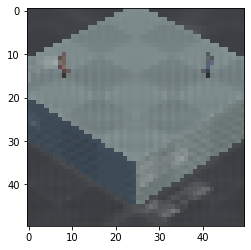

In [23]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Initialize environment, gather initial state
end, reward, state = environment.reset()

screen = environment.state2image(state)
plt.imshow(screen)
screen_shape = np.shape(screen)
n_actions = 3

#TODO: make a direct state2input function
def image2input(screen):
    """ Converts an image gained from the environment (through environment.state2image) to ready-to-use input"""
    # Transpose to pytorch order of dimensions (cwh)
    screen = np.transpose(screen, axes=(2,0,1))
    # Translate to rgb float values
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Convert to tensor
    screen = torch.from_numpy(screen)
    # Add batch dimension, yeet to device
    screen = screen.unsqueeze(0).to(device)
    return screen
    

# Initialize DQN network
policy_net = DQN(screen_shape[0], screen_shape[1], n_actions).to(device)
target_net = DQN(screen_shape[0], screen_shape[1], n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
episode_durations = []


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [24]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
num_episodes = 10_000
steps_done = 0

for i_episode in range(num_episodes):
    timer = time.time()
    
    # Initialize the environment and state
    end, reward, state = environment.reset()
    state = image2input(environment.state2image(state))
    last_state = state
    current_state = state
    state = current_state - last_state
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        end, reward, state = environment.step(action.item())
        if reward == 10:
            print("Victory!!!!")
        #reward += 20
        state = image2input(environment.state2image(state))
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_state = current_state
        current_state = state
        if not end:
            next_state = current_state - last_state
        else:
            next_state = None


        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if end:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    print("episode", i_episode, "completed in", time.time() - timer)
    
    if (i_episode+1)%500 == 0:
        torch.save(policy_net.state_dict(), "dict_e" + str(i_episode+1) +".kek")
        

print('Complete')
# env.render()
# env.close()
plt.ioff()
plt.show()

episode 0 completed in 1.9254088401794434
episode 1 completed in 1.4303083419799805
episode 2 completed in 1.4782333374023438
episode 3 completed in 11.774239778518677
episode 4 completed in 6.268260717391968
episode 5 completed in 3.6363213062286377
episode 6 completed in 5.031483173370361
episode 7 completed in 3.143456220626831
episode 8 completed in 4.654305696487427
episode 9 completed in 3.1546685695648193
episode 10 completed in 3.368500232696533
episode 11 completed in 4.702929973602295
episode 12 completed in 5.928964614868164
Victory!!!!
episode 13 completed in 30.017076015472412
episode 14 completed in 4.158254623413086
episode 15 completed in 7.528879404067993
episode 16 completed in 5.463927268981934
episode 17 completed in 14.687218189239502
episode 18 completed in 5.5579118728637695
Victory!!!!
episode 19 completed in 8.098037719726562
Victory!!!!
episode 20 completed in 5.265378475189209
episode 21 completed in 10.929947853088379
episode 22 completed in 7.61824107170105

episode 190 completed in 3.8972957134246826
episode 191 completed in 3.6783244609832764
episode 192 completed in 9.363072633743286
episode 193 completed in 3.23903226852417
episode 194 completed in 4.249632358551025
episode 195 completed in 3.2767221927642822
episode 196 completed in 3.4450550079345703
episode 197 completed in 2.835170030593872
episode 198 completed in 3.4107251167297363
episode 199 completed in 2.883730411529541
episode 200 completed in 3.2942776679992676
episode 201 completed in 3.43983793258667
episode 202 completed in 3.6281886100769043
episode 203 completed in 10.402917623519897
episode 204 completed in 4.480947732925415
episode 205 completed in 3.4631075859069824
episode 206 completed in 4.052212715148926
episode 207 completed in 4.854167222976685
episode 208 completed in 5.923139810562134
episode 209 completed in 7.105529069900513
episode 210 completed in 6.1396074295043945
episode 211 completed in 4.772719383239746
episode 212 completed in 4.851743221282959
epi

episode 378 completed in 5.214808702468872
episode 379 completed in 5.858269214630127
episode 380 completed in 3.9485414028167725
Victory!!!!
episode 381 completed in 9.683855533599854
episode 382 completed in 10.757757186889648
episode 383 completed in 5.8277528285980225
episode 384 completed in 4.995927095413208
episode 385 completed in 5.0105812549591064
episode 386 completed in 9.55979061126709
episode 387 completed in 5.787640333175659
episode 388 completed in 3.3595705032348633
Victory!!!!
episode 389 completed in 6.184501647949219
episode 390 completed in 5.827393531799316
episode 391 completed in 19.719939708709717
episode 392 completed in 5.482762575149536
episode 393 completed in 6.994126319885254
episode 394 completed in 4.280961275100708
episode 395 completed in 5.8017988204956055
episode 396 completed in 4.832109451293945
Victory!!!!
episode 397 completed in 14.247764348983765
episode 398 completed in 3.1668810844421387
episode 399 completed in 4.648404836654663
episode 40

Victory!!!!
episode 565 completed in 5.831384658813477
episode 566 completed in 7.295845031738281
episode 567 completed in 7.747687101364136
episode 568 completed in 21.887722492218018
episode 569 completed in 6.8979151248931885
episode 570 completed in 5.682356834411621
episode 571 completed in 6.51105809211731
episode 572 completed in 5.424005508422852
episode 573 completed in 6.508103609085083
episode 574 completed in 5.897700548171997
episode 575 completed in 14.398019552230835
episode 576 completed in 9.135342597961426
episode 577 completed in 4.875562906265259
episode 578 completed in 10.335356712341309
episode 579 completed in 5.586841344833374
Victory!!!!
episode 580 completed in 11.723074674606323
episode 581 completed in 6.964792013168335
episode 582 completed in 7.128393888473511
episode 583 completed in 6.3571271896362305
episode 584 completed in 5.703416109085083
episode 585 completed in 7.578408718109131
episode 586 completed in 3.484103202819824
episode 587 completed in 

episode 753 completed in 4.088343381881714
episode 754 completed in 5.041597127914429
episode 755 completed in 3.4921579360961914
episode 756 completed in 7.198312997817993
episode 757 completed in 4.221566677093506
episode 758 completed in 5.741630792617798
episode 759 completed in 8.645473003387451
episode 760 completed in 6.0209105014801025
episode 761 completed in 8.569266557693481
episode 762 completed in 3.2797329425811768
episode 763 completed in 4.4719765186309814
episode 764 completed in 9.244301795959473
episode 765 completed in 7.686611175537109
episode 766 completed in 7.547445774078369
episode 767 completed in 4.4327991008758545
episode 768 completed in 6.56484580039978
episode 769 completed in 11.88534426689148
episode 770 completed in 6.831640720367432
episode 771 completed in 4.89519739151001
episode 772 completed in 8.216665029525757
episode 773 completed in 4.688817024230957
episode 774 completed in 7.76660680770874
episode 775 completed in 4.260005474090576
episode 7

episode 941 completed in 6.998459577560425
episode 942 completed in 8.149971723556519
episode 943 completed in 9.52654504776001
episode 944 completed in 5.281314849853516
episode 945 completed in 6.579164743423462
episode 946 completed in 5.5767834186553955
episode 947 completed in 6.633160591125488
episode 948 completed in 3.43327260017395
Victory!!!!
episode 949 completed in 6.175627708435059
episode 950 completed in 6.3979761600494385
episode 951 completed in 35.33280110359192
episode 952 completed in 4.964783191680908
episode 953 completed in 5.505478858947754
episode 954 completed in 13.714868307113647
episode 955 completed in 7.004079818725586
episode 956 completed in 4.572246551513672
episode 957 completed in 8.687077045440674
episode 958 completed in 8.142986297607422
episode 959 completed in 9.891589641571045
episode 960 completed in 15.095601797103882
episode 961 completed in 3.705867052078247
episode 962 completed in 6.122009038925171
episode 963 completed in 6.1052949428558

episode 1127 completed in 6.4006617069244385
episode 1128 completed in 5.403731822967529
Victory!!!!
episode 1129 completed in 41.01310586929321
episode 1130 completed in 7.562666177749634
episode 1131 completed in 4.901163339614868
episode 1132 completed in 4.449529409408569
episode 1133 completed in 7.107027769088745
episode 1134 completed in 7.022767543792725
episode 1135 completed in 7.2751476764678955
episode 1136 completed in 5.5555994510650635
episode 1137 completed in 10.925364971160889
episode 1138 completed in 8.320725917816162
episode 1139 completed in 7.267321825027466
episode 1140 completed in 5.604618787765503
episode 1141 completed in 17.515112161636353
episode 1142 completed in 29.634013414382935
episode 1143 completed in 5.5659403800964355
episode 1144 completed in 8.56726622581482
episode 1145 completed in 4.464462041854858
episode 1146 completed in 6.282367944717407
episode 1147 completed in 5.930433511734009
episode 1148 completed in 5.356390476226807
episode 1149 c

episode 1311 completed in 8.139626026153564
episode 1312 completed in 6.466113805770874
episode 1313 completed in 3.8259029388427734
episode 1314 completed in 3.209077835083008
episode 1315 completed in 6.0479514598846436
episode 1316 completed in 7.733477354049683
episode 1317 completed in 3.412163257598877
episode 1318 completed in 6.100988388061523
episode 1319 completed in 18.71973967552185
episode 1320 completed in 5.347086191177368
episode 1321 completed in 9.99875783920288
episode 1322 completed in 4.09832239151001
episode 1323 completed in 4.972331285476685
episode 1324 completed in 5.293639421463013
episode 1325 completed in 5.876598358154297
episode 1326 completed in 7.359611749649048
episode 1327 completed in 4.294704914093018
episode 1328 completed in 7.689323425292969
episode 1329 completed in 5.62764310836792
episode 1330 completed in 3.705061912536621
episode 1331 completed in 6.546762943267822
episode 1332 completed in 5.099671125411987
episode 1333 completed in 5.11711

episode 1494 completed in 9.241010665893555
episode 1495 completed in 5.562108278274536
episode 1496 completed in 5.847444772720337
episode 1497 completed in 7.048614025115967
episode 1498 completed in 5.896445989608765
episode 1499 completed in 9.064696788787842
episode 1500 completed in 6.468842029571533
Victory!!!!
episode 1501 completed in 6.307140827178955
episode 1502 completed in 8.774248361587524
episode 1503 completed in 11.559065580368042
episode 1504 completed in 9.452719926834106
episode 1505 completed in 6.886860370635986
episode 1506 completed in 8.116795301437378
episode 1507 completed in 4.440228223800659
Victory!!!!
episode 1508 completed in 6.516010046005249
episode 1509 completed in 10.713701486587524
episode 1510 completed in 12.282565116882324
episode 1511 completed in 6.252554178237915
episode 1512 completed in 7.538814067840576
episode 1513 completed in 20.970558643341064
episode 1514 completed in 12.886963844299316
episode 1515 completed in 15.388325929641724
Vi

episode 1675 completed in 8.775324583053589
episode 1676 completed in 35.965221881866455
episode 1677 completed in 11.291792631149292
episode 1678 completed in 19.04959988594055
episode 1679 completed in 6.284065246582031
episode 1680 completed in 4.480710506439209
episode 1681 completed in 19.850173234939575
episode 1682 completed in 12.849197626113892
episode 1683 completed in 3.529137372970581
episode 1684 completed in 5.897808074951172
episode 1685 completed in 4.199451446533203
episode 1686 completed in 5.922244548797607
episode 1687 completed in 7.41087532043457
episode 1688 completed in 4.844306945800781
episode 1689 completed in 5.0182013511657715
episode 1690 completed in 14.71007490158081
episode 1691 completed in 7.5677878856658936
episode 1692 completed in 7.0644004344940186
episode 1693 completed in 4.8480353355407715
episode 1694 completed in 7.568526744842529
episode 1695 completed in 7.587880611419678
episode 1696 completed in 6.20986008644104
episode 1697 completed in 

episode 1859 completed in 5.499270915985107
Victory!!!!
episode 1860 completed in 9.164723873138428
episode 1861 completed in 7.146330118179321
episode 1862 completed in 3.3237507343292236
episode 1863 completed in 9.041206359863281
episode 1864 completed in 3.4908621311187744
Victory!!!!
episode 1865 completed in 5.417553186416626
Victory!!!!
episode 1866 completed in 26.104544162750244
episode 1867 completed in 13.638216018676758
episode 1868 completed in 6.272026538848877
episode 1869 completed in 3.1546783447265625
episode 1870 completed in 6.96333122253418
episode 1871 completed in 3.4851808547973633
episode 1872 completed in 5.584546327590942
episode 1873 completed in 15.388155221939087
episode 1874 completed in 11.663297414779663
episode 1875 completed in 5.23190975189209
episode 1876 completed in 4.239425420761108
episode 1877 completed in 4.6742565631866455
episode 1878 completed in 6.304838180541992
episode 1879 completed in 5.395507574081421
episode 1880 completed in 4.82529

episode 2039 completed in 5.025554418563843
episode 2040 completed in 5.830838441848755
episode 2041 completed in 2.667701005935669
episode 2042 completed in 5.107438564300537
episode 2043 completed in 4.4125213623046875
episode 2044 completed in 5.059866189956665
episode 2045 completed in 2.837620258331299
episode 2046 completed in 5.378067255020142
episode 2047 completed in 7.906118869781494
episode 2048 completed in 5.860290765762329
episode 2049 completed in 2.7114181518554688
episode 2050 completed in 5.61114764213562
episode 2051 completed in 4.1597161293029785
episode 2052 completed in 3.636601448059082
episode 2053 completed in 4.5082409381866455
episode 2054 completed in 11.11596393585205
episode 2055 completed in 3.3162221908569336
episode 2056 completed in 2.7352213859558105
episode 2057 completed in 2.8465888500213623
episode 2058 completed in 5.430177927017212
episode 2059 completed in 7.280916213989258
episode 2060 completed in 6.322005271911621
episode 2061 completed in 

episode 2222 completed in 10.46036434173584
Victory!!!!
episode 2223 completed in 9.245298147201538
episode 2224 completed in 4.897989749908447
episode 2225 completed in 13.023733854293823
episode 2226 completed in 8.85539960861206
episode 2227 completed in 6.979711294174194
episode 2228 completed in 8.192039489746094
episode 2229 completed in 5.42438817024231
episode 2230 completed in 5.572707653045654
episode 2231 completed in 10.355072975158691
episode 2232 completed in 4.062883615493774
episode 2233 completed in 5.260483980178833
episode 2234 completed in 5.5152809619903564
episode 2235 completed in 4.305904865264893
episode 2236 completed in 9.927873373031616
episode 2237 completed in 3.3858301639556885
episode 2238 completed in 3.0621299743652344
episode 2239 completed in 8.394468545913696
episode 2240 completed in 3.7516562938690186
episode 2241 completed in 3.398855209350586
episode 2242 completed in 6.601832628250122
episode 2243 completed in 3.2479145526885986
episode 2244 co

episode 2406 completed in 4.676514387130737
episode 2407 completed in 8.055978059768677
episode 2408 completed in 3.664552927017212
episode 2409 completed in 3.332930088043213
episode 2410 completed in 3.8499138355255127
episode 2411 completed in 4.90175724029541
episode 2412 completed in 12.67504072189331
episode 2413 completed in 3.4186854362487793
episode 2414 completed in 7.038793325424194
episode 2415 completed in 3.0909268856048584
episode 2416 completed in 6.064808130264282
Victory!!!!
episode 2417 completed in 6.804075002670288
episode 2418 completed in 4.633934497833252
episode 2419 completed in 2.6237947940826416
episode 2420 completed in 9.53208589553833
episode 2421 completed in 35.24859404563904
episode 2422 completed in 5.364025354385376
episode 2423 completed in 5.116122245788574
episode 2424 completed in 3.261122703552246
episode 2425 completed in 4.8710925579071045
episode 2426 completed in 5.981533050537109
episode 2427 completed in 6.042463064193726
episode 2428 comp

episode 2589 completed in 4.348455905914307
episode 2590 completed in 3.46488094329834
Victory!!!!
episode 2591 completed in 9.212880611419678
episode 2592 completed in 5.622979402542114
episode 2593 completed in 2.8539907932281494
episode 2594 completed in 7.255602121353149
episode 2595 completed in 4.1338677406311035
episode 2596 completed in 3.8425254821777344
episode 2597 completed in 6.49913763999939
episode 2598 completed in 11.679856300354004
Victory!!!!
episode 2599 completed in 7.534062385559082
episode 2600 completed in 3.0405635833740234
episode 2601 completed in 3.212343692779541
episode 2602 completed in 2.9189956188201904
episode 2603 completed in 11.253466606140137
episode 2604 completed in 7.161795377731323
episode 2605 completed in 2.9935855865478516
episode 2606 completed in 4.803797960281372
episode 2607 completed in 3.634805202484131
episode 2608 completed in 7.886913776397705
episode 2609 completed in 3.8625853061676025
Victory!!!!
episode 2610 completed in 34.1868

episode 2772 completed in 4.848778963088989
episode 2773 completed in 6.03406023979187
episode 2774 completed in 5.612277030944824
episode 2775 completed in 6.137663841247559
episode 2776 completed in 6.294034004211426
episode 2777 completed in 21.27564001083374
Victory!!!!
episode 2778 completed in 6.885279655456543
episode 2779 completed in 8.053664445877075
episode 2780 completed in 6.180232286453247
episode 2781 completed in 4.130081653594971
episode 2782 completed in 5.0159690380096436
episode 2783 completed in 10.352924823760986
episode 2784 completed in 11.848735094070435
episode 2785 completed in 5.335900783538818
episode 2786 completed in 3.4303979873657227
Victory!!!!
episode 2787 completed in 27.502466440200806
episode 2788 completed in 32.818832874298096
episode 2789 completed in 4.071812152862549
episode 2790 completed in 12.899222373962402
episode 2791 completed in 6.0563437938690186
episode 2792 completed in 3.8359861373901367
episode 2793 completed in 7.946742296218872


episode 2954 completed in 6.610747337341309
episode 2955 completed in 7.2797017097473145
episode 2956 completed in 6.309553384780884
episode 2957 completed in 5.2003185749053955
episode 2958 completed in 6.851409912109375
episode 2959 completed in 4.26283860206604
Victory!!!!
episode 2960 completed in 9.366856098175049
episode 2961 completed in 3.05320405960083
episode 2962 completed in 7.773196458816528
Victory!!!!
episode 2963 completed in 13.078446388244629
episode 2964 completed in 11.520734310150146
episode 2965 completed in 10.913835048675537
episode 2966 completed in 6.399458885192871
episode 2967 completed in 6.104001522064209
episode 2968 completed in 6.058861494064331
episode 2969 completed in 5.070111513137817
episode 2970 completed in 5.11754584312439
episode 2971 completed in 4.245619535446167
episode 2972 completed in 8.0454843044281
episode 2973 completed in 8.781811714172363
episode 2974 completed in 2.6465094089508057
episode 2975 completed in 4.240734100341797
episode

Victory!!!!
episode 3135 completed in 36.34374475479126
episode 3136 completed in 3.750488519668579
episode 3137 completed in 6.253702640533447
episode 3138 completed in 4.8308422565460205
episode 3139 completed in 5.512974739074707
episode 3140 completed in 8.165806531906128
episode 3141 completed in 20.302035331726074
episode 3142 completed in 5.0390496253967285
episode 3143 completed in 5.970276832580566
episode 3144 completed in 8.981773853302002
episode 3145 completed in 13.115358591079712
episode 3146 completed in 5.0445942878723145
episode 3147 completed in 4.538635015487671
episode 3148 completed in 6.753742694854736
episode 3149 completed in 6.068188428878784
episode 3150 completed in 5.81963324546814
episode 3151 completed in 8.188552141189575
episode 3152 completed in 6.66827654838562
episode 3153 completed in 8.025834321975708
episode 3154 completed in 7.1794445514678955
episode 3155 completed in 4.988666534423828
episode 3156 completed in 8.01505446434021
episode 3157 comp

episode 3318 completed in 6.2244956493377686
episode 3319 completed in 3.500999689102173
episode 3320 completed in 6.1427905559539795
episode 3321 completed in 13.344732284545898
episode 3322 completed in 7.675613641738892
episode 3323 completed in 4.8447582721710205
Victory!!!!
episode 3324 completed in 5.100544691085815
Victory!!!!
episode 3325 completed in 8.212264060974121
episode 3326 completed in 3.529855251312256
episode 3327 completed in 8.083459615707397
Victory!!!!
episode 3328 completed in 9.825435161590576
episode 3329 completed in 12.215410709381104
episode 3330 completed in 3.66249680519104
episode 3331 completed in 4.537767171859741
episode 3332 completed in 5.665913105010986
episode 3333 completed in 5.177230358123779
episode 3334 completed in 4.464646339416504
episode 3335 completed in 7.39085841178894
Victory!!!!
episode 3336 completed in 6.933548927307129
episode 3337 completed in 11.62425971031189
episode 3338 completed in 16.441828966140747
Victory!!!!
episode 3339

episode 3498 completed in 4.60970664024353
episode 3499 completed in 5.6709630489349365
Victory!!!!
episode 3500 completed in 21.98493266105652
episode 3501 completed in 19.338825702667236
episode 3502 completed in 4.068343877792358
episode 3503 completed in 13.673021078109741
episode 3504 completed in 7.029097557067871
episode 3505 completed in 5.904346227645874
episode 3506 completed in 6.660315036773682
episode 3507 completed in 12.588647603988647
episode 3508 completed in 6.768015146255493
episode 3509 completed in 9.05174708366394
episode 3510 completed in 7.267921209335327
episode 3511 completed in 5.009546995162964
episode 3512 completed in 6.246851921081543
episode 3513 completed in 6.712853193283081
episode 3514 completed in 6.4926745891571045
episode 3515 completed in 8.150156021118164
episode 3516 completed in 16.409905195236206
episode 3517 completed in 3.6397969722747803
episode 3518 completed in 7.06390905380249
episode 3519 completed in 6.348073720932007
episode 3520 com

In [ ]:
# Together with next cell, test function to compute difference between last and current screen

end, reward, state = environment.reset()

last_screen = environment.state2image(state)
curr_screen = environment.state2image(environment.step(0)[2])
diff = ImageChops.difference(curr_screen, last_screen)
plt.imshow(diff)

In [ ]:
# Together with previous cell, test function to compute difference between last and current screen
last_screen = curr_screen
curr_screen = environment.state2image(environment.step(0)[2])
diff = ImageChops.difference(curr_screen, last_screen)
plt.imshow(diff)